importing Jupyter notebook from Volume4Project.ipynb


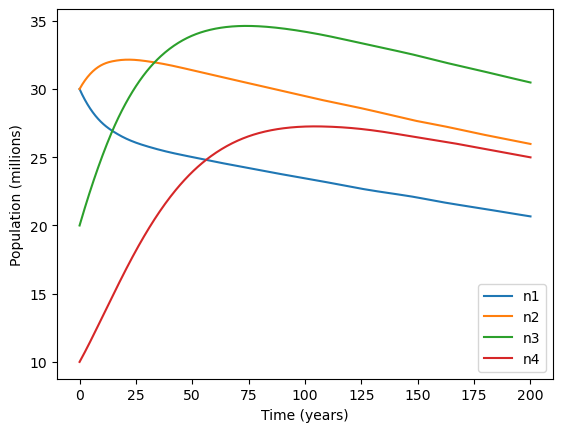

Stored 'get_deltas' (function)
Stored 'population_SIR' (function)
Stored 'sol' (OdeResult)


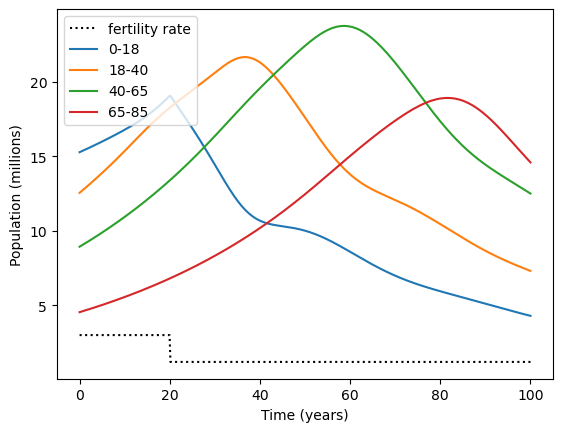

With capital this time as well.


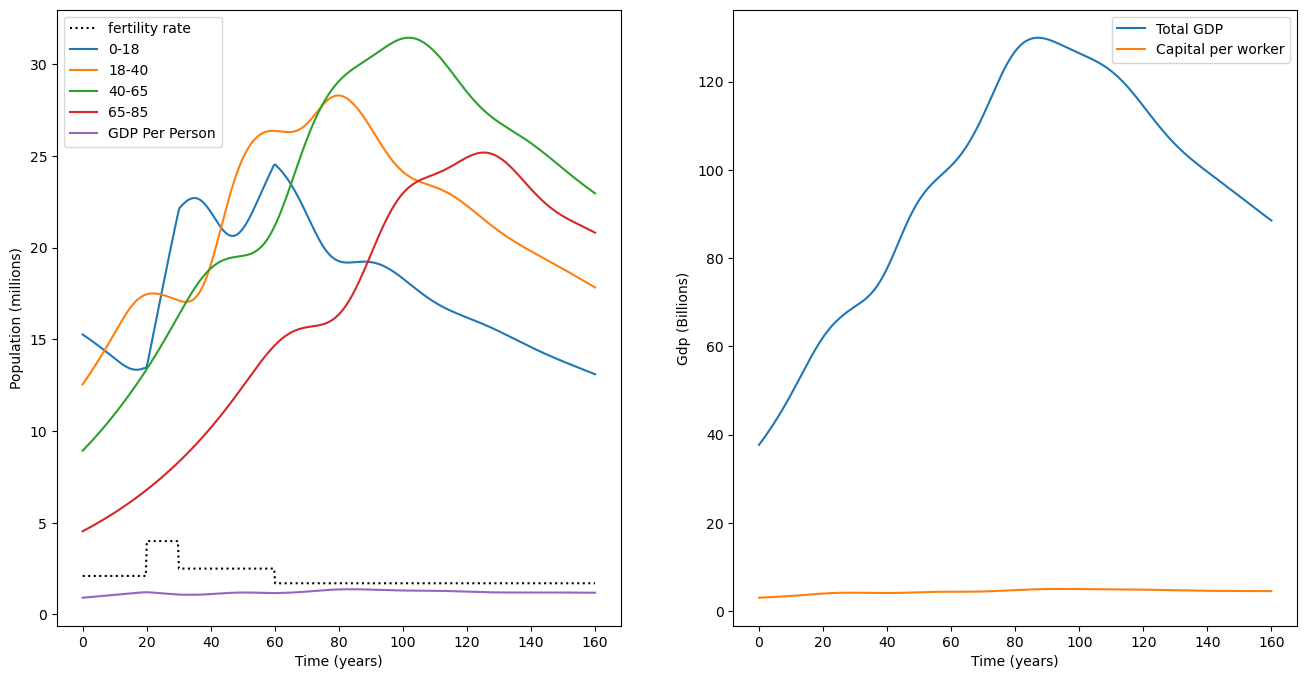

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy.linalg as la
import import_ipynb
import Volume4Project as v4
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

## Importing Population Data from Andrew's work

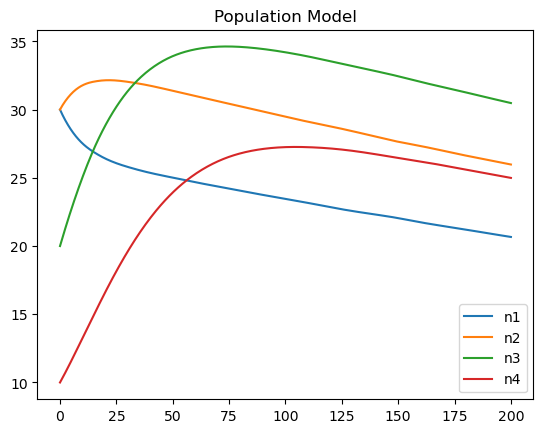

In [3]:
%store -r sol 

N_matrix = sol.y
domain = sol.t
for i in range(4):
    plt.plot(sol.t, N_matrix[i,:], label="n"+str(i+1))
plt.title("Population Model")
plt.legend()
plt.show()

In [4]:
# Define constants

# Model for the U.S
alpha = 0.4                            # For developed countries
A = 1                                  # Assume constant technology
delta = 0.037                          # Depreciation rate of capital.
domain = sol.t # Subject to change
k0_list = [1, 8, 15]
t_span = (0,domain[-1])
s = 0.4

def n(t):
    if t not in domain: # If the input is not found in the domain, map it to the nearest domain value
        t1 = np.argmin(la.norm(domain-t))
    else:
        t1 = t
    index = np.where(domain == t1)[0]
    return N_matrix[:,index[0]]
n = np.vectorize(n)


# Calculate the sum of the whole population
N = np.sum(N_matrix, axis=0)

lfgr_array = np.gradient(N)

def lfgr(t):
    if t not in domain: # If the input is not found in the domain, map it to the nearest domain value
        t1 = np.argmin(la.norm(domain-t))
    else:
        t1 = t
    index = np.where(domain == t1)[0]
    return lfgr_array[index[0]]
lfgr = np.vectorize(lfgr)  

lfgr = lambda t: 0.01 # For now, I will assume that the Labor force growth rate is constant, despite the population changes.

## Productivity Variation

The Solow Growth Model can also be used to understand the effects of worker productivity on the GDP growth of a country. In order to do this, we introduce a variation to the Solow Growth model.

This variation of the model factors for different levels of productivity depending on the age of the worker. The age groups are divided into 0-18 years, 18-40 years, 40-65 years, and 65-85 years. Each age group has a different level of productivity in the economy and is assigned a different weight based on their average productivity. 

Worker productivity is reflected in the production function of the Solow Growth Model. The traditional model defines the production function as:

$$y(t) = A(t)k(t)^{\alpha}$$

We will account for age-group productivity by introducing two vectors $n(t), p \in \mathbb{R}^4$. n(t) is the proportion of population in each age group at each time t, and p contains the weights for each age group. For our model, we will use the population data provided previously from the SIR model.

The model is adjusted by taking the standard inner product of p and n, normalizing this term with respect to n, and multiplying this term to our production function, as follows.

$$y(t) = A(t)k(t)^{\alpha} \frac{p\cdot \vec{n}}{\lVert \vec{n} \rVert _{1}} $$

Despite the population shifts, for this model, we will assume that the labor force growth rate is still constant, with a value of 0.01.

In [5]:
def Solow_productivity(t,k, p = np.array([1,1,1,1])):
    """Models the Solow growth curve, but with the variation that productivity depends on population class
    Parameters:
    t (float) - The time element
    k (callable function) - Capital. This is the dependent variable
    """
    y = A * (k**alpha) * np.dot(p,n(t)) / (np.sum(n(t)))
    return s*y - (delta + lfgr(t))*k

Choosing the correct weights for each age group is important to creating an accurate model. The weights only matter relative to one another. As such, we will consider the age group 41-65 as "unit productive". All other weights will be in relation to this weight. For a standard productivity model, we chose the following weights.

$$ p = [0.1, 0.8, 1.0, 0.3] $$

- Individuals in the range of 0-18 years often do not work and even if they do, their labor is generally not as productive as it would be later in life due to lack of education. Therefore, we assigned this group a weight of 0.1

- The 19-40 age group represents a majority of the work force, but also includes college-age students, which will result in a slight decrease in productivity. As a result, this group was assigned a weight of 0.8.

- The 41-65 age group represents the older bracket of workers. This age group was considered the most productive because these individuals are generally finished with their education and can devote all their time to working, and benefit from having more experience than the previous two age groups.

- Most members of the 66-85 age group are retired or are relatively unproductive workers. This group was given a weight of 0.3.

The standard Solow growth model can be fit into this framework by averaging the weights and creating a constant $\overline p$ vector. In this case, $\overline p = [0.55, 0.55, 0.55, 0.55]$.

The graphs below show the difference between the typical Solow growth model along with the worker productivity variation for a few different initial capital conditions.

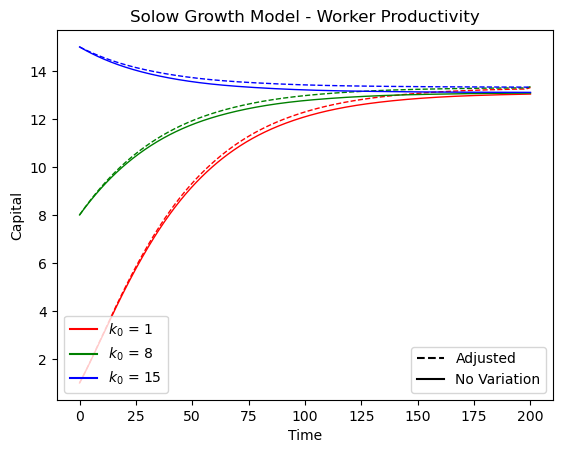

In [6]:
p_list = [np.array([0.1, 0.8, 1.0, 0.3]), np.array([0.55, 0.55, 0.55, 0.55])]
label_list = ["Adjusted", "No Variation"]
colors = ["red", "green", "blue"]
line_style = ["--", "-"]
color_legend = []
style_legend = []

for p, lin in zip(p_list, line_style):
    for k0, color in zip(k0_list, colors):
        k = solve_ivp(Solow_productivity, t_span, [k0], t_eval=domain, args=[p,])
        ax, = plt.plot(k.t, k.y[0], lin, color=color, linewidth=1)
        
        # Add data that simplifies the legend
        colorLine = Line2D([0,1],[0,1], linestyle='-', color=color)
        color_legend.append(colorLine)
    
    styleLine = Line2D([0,1],[0,1], linestyle=lin, color="black")    
    style_legend.append(styleLine)
        

legend1 = plt.legend(color_legend, [r"$k_0$" + " = " + str(k0) for k0 in k0_list], loc=3)
plt.legend(style_legend, label_list, loc=4)
plt.gca().add_artist(legend1)
plt.title("Solow Growth Model - Worker Productivity")
plt.xlabel("Time")
plt.ylabel("Capital")
plt.show()

Based on the graph above, we can see that adjusting the worker productivity leads to a slightly higher steady-state solution than the original model. Since the weights were chosen somewhat arbitrarily, the exact relation between the adjusted model and the original model shouldn't be taken as significant. However, it is clear that both models have a similar shape and steady-state solution. Therefore, we can conclude that the Solow Growth Model's assumptions regarding worker productivity, while unreasonable, do not affect the outcome in a significant way.

## Retirement Age Shift

The worker productivity model can be used to model various changes in the workforce: for example, a nation-wide shift in the retirement age. For example, if the retirement age increased, this would correspond to slightly higher productivity in the highest age bracket.

In the graph below, we compare a retirement age increase with the standard productivity variation introduced above. The only difference is in the weights. For the retirement age increase, we raised the $p_4$ value from 0.3 to 0.4. For simplicity, we assume that this is the only way that the retirement age would affect GDP.

Therefore, our new p vector is $$ p = [0.1, 0.8, 1.0, 0.4] $$

The results of this adjustment are as follows:

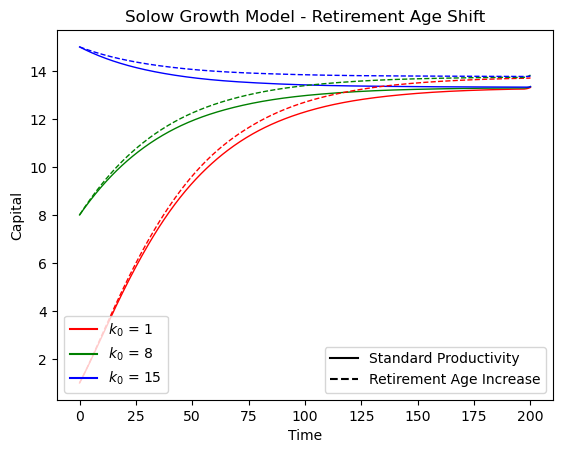

In [11]:
p_list = [np.array([0.1, 0.8, 1.0, 0.3]), np.array([0.1, 0.8, 1.0, 0.4])]
label_list = ["Standard Productivity", "Retirement Age Increase"]
colors = ["red", "green", "blue"]
line_style = ["-", "--"]
color_legend = []
style_legend = []

for p, lin in zip(p_list, line_style):
    for k0, color in zip(k0_list, colors):
        k = solve_ivp(Solow_productivity, t_span, [k0], t_eval=domain, args=[p,])
        ax, = plt.plot(k.t, k.y[0], lin, color=color, linewidth=1)
        
        # Add data that simplifies the legend
        colorLine = Line2D([0,1],[0,1], linestyle='-', color=color)
        color_legend.append(colorLine)
        
    styleLine = Line2D([0,1],[0,1], linestyle=lin, color="black")
    style_legend.append(styleLine)

    
legend1 = plt.legend(color_legend, [r"$k_0$" + " = " + str(k0) for k0 in k0_list], loc=3)
plt.legend(style_legend, label_list, loc=4)
plt.gca().add_artist(legend1)
plt.title("Solow Growth Model - Retirement Age Shift")
plt.xlabel("Time")
plt.ylabel("Capital")
plt.show()

Similar to before, the variation for retirement age results in higher production and a higher steady-state, but the shape of the graph is the same.  

## Generational Saving Habits

We can also adjust our model by relaxing the universal constant savings rate assumption. We do this by partitioning the saving habits of each generation. In a similar fashion to the productivity case, we can assign weights to each generation. Adding savings weights requires adjusting our model to the following formulae:

$$y(t) = A(t)k(t)^{\alpha}$$
$$c(t) + i(t) = y(t)$$
$$ \frac{\vec{s} \cdot \vec{n}}{\lVert \vec{n} \rVert _{1}}y(t) = i(t)$$
$$\dot k = \frac{\vec{s} \cdot \vec{n}}{\lVert \vec{n} \rVert _{1}} y(t) - (\delta + \Delta n)k(t)$$

The key difference in this model is that the constant s becomes a vector $\vec{s}$, which is dotted with our population vector $\vec{n}$ and then normalized by population, as before. Note that $\Delta n$ is used to denote the labor force growth rate (to avoid confusion with the population $\vec{n}$). $\Delta n$ is still assumed to be constant.

We define the savings rate vector to be as follows:
$$ \vec{s} = [0.2, 0.6, 0.8, 1] $$

Based on the information found in [https://www.lendingclub.com/resource-center/personal-savings/understanding-average-americans-savings-by-age], the median savings for individuals in the United States is nearly monotonically increasing. We infer that this is primarily due to the accumulation of wealth over time for the typical individual. Therefore, we consider the highest savings bracket, ages 61-85, to be "unit savers" and each younger generation saves less.

The graphs below compare this savings model to the standard model. Again, the standard model can be fit into this framework by averaging the weights and creating a constant $\overline s$ vector. In this case, $\overline s = [0.65, 0.65, 0.65, 0.65]$.

In [12]:
def Solow_savings(t,k, S = np.array([0.65,0.65,0.65,0.65])):
    """Models the Solow growth curve, but with the variation that productivity depends on population class
    Parameters:
    t (float) - The time element
    k (callable function) - Capital. This is the dependent variable
    """
    y = A * (k**alpha)
    i = np.dot(S,n(t))*y / np.sum(n(t))
    return i - (delta + lfgr(t))*k

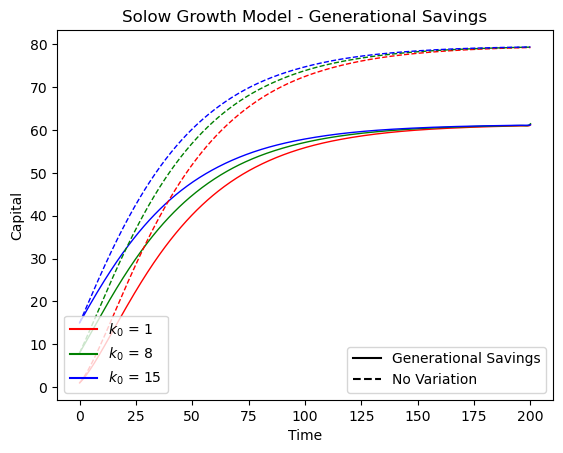

In [13]:
s_list = [np.array([0.2, 0.6, 0.8, 1.0]), np.array([0.65, 0.65, 0.65, 0.65])]
label_list = ["Generational Savings", "No Variation"]
colors = ["red", "green", "blue"]
line_style = ["-", "--"]
color_legend = []
style_legend = []

for S, lin in zip(s_list, line_style):
    for k0, color in zip(k0_list, colors):
        k = solve_ivp(Solow_savings, t_span, [k0], t_eval=domain, args=[S,])
        ax, = plt.plot(k.t, k.y[0], lin, color=color, linewidth=1)
        
        # Add data that simplifies the legend
        colorLine = Line2D([0,1],[0,1], linestyle='-', color=color)
        color_legend.append(colorLine)
        
    styleLine = Line2D([0,1],[0,1], linestyle=lin, color="black")
    style_legend.append(styleLine)


legend1 = plt.legend(color_legend, [r"$k_0$" + " = " + str(k0) for k0 in k0_list], loc=3)
plt.legend(style_legend, label_list, loc=4)
plt.gca().add_artist(legend1)

plt.title("Solow Growth Model - Generational Savings")
plt.xlabel("Time")
plt.ylabel("Capital")
plt.show()

The graphs show a significant decrease in capital when generational savings is included, but the shape of the graphs are the same. This goes to show that the savings rate plays a major role in determining the generated capital. Since the shape of the variation graph is similar to the original model, we can conclude that the Solow growth model is robust to partitioning the savings rate. 

Again, the weights were constructed with some economic intuition, but were not empirically observed. The worker productivity and generational savings models could potentially be improved by empirically estimating the weights for each age group, but this falls outside the scope of this project.

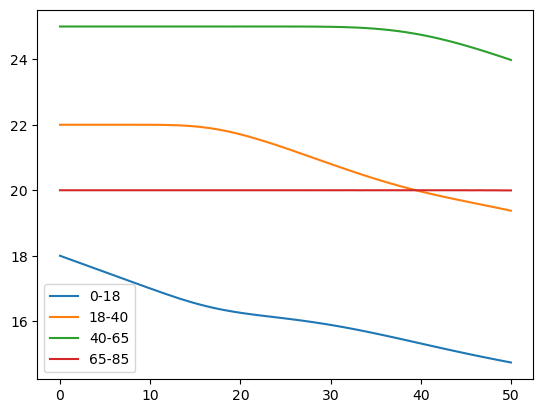

In [10]:
# Here's how to implement Andrew's Code

def weights(x):
    """x is the age of an individual"""
    """Be careful about double-counting age groups."""
    return (x>=18)*.4+(x>=40)*.6 - (x >= 65)*.6

# Define your parameters
test = v4.Solow_Model_Parameters(A = 5, weights = weights)

# Construct the model and prepare it
model = v4.Population_Solow_Model(fertility_rate = 1.8, solow_growth_parameters = test).prep_model()

# Define an initial population
init_pop = np.array([1]*85)

# Solve the model
solution = model.solve(t_points = np.linspace(0,50,100), starting_population=init_pop, starting_capital=1)

# Optionally, you could consolidate the age groups
values, labels = v4.consolidate_age_groups(solution.population, return_labels=True)
plt.plot(np.linspace(0,50,100), values.T, label=labels)
plt.legend()
plt.show()